## Load Data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc as sk_auc, precision_recall_curve  # Burada sk_auc dedik
import pandas as pd
import pandas as pd
import kagglehub

CIC_path = kagglehub.dataset_download("dhoogla/nf-cse-cic-ids2018")

try:
    # Read only the first 5 rows to save memory/time for now
    CIC_df = pd.read_parquet(CIC_path)
    print("Successfully loaded sample data:")
    print(CIC_df.columns.tolist())
    display(CIC_df.head())
except FileNotFoundError:
    print(f"Error: Could not find file in {CIC_path}")

Using Colab cache for faster access to the 'nf-cse-cic-ids2018' dataset.
Successfully loaded sample data:
['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,51128,443,6,91.000000,152,0,3,0,194,4285680,0,Benign
1,443,51036,6,91.178001,994,979,7,7,24,4234714,0,Benign
2,12262,445,6,0.000000,585,344,5,4,30,4294106,0,Benign
3,61023,53,17,0.000000,136,168,2,2,0,4293985,0,Benign
4,443,51037,6,91.178001,72,40,1,1,24,4294845,0,Benign


In [2]:
import pandas as pd
import kagglehub

NB15_path = kagglehub.dataset_download("dhoogla/nfunswnb15")

try:
    # Read only the first 5 rows to save memory/time for now
    NB15_df = pd.read_parquet(NB15_path)
    print("Successfully loaded sample data:")
    print(NB15_df.columns.tolist())
    display(NB15_df.head())
except FileNotFoundError:
    print(f"Error: Could not find file in {NB15_path}")

Using Colab cache for faster access to the 'nfunswnb15' dataset.
Successfully loaded sample data:
['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,62073,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,32284,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,21,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,23800,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,63062,21,6,1.0,1786,2340,32,34,25,1459,0,Benign


## Data preprocessing

#### Feature Selection

In [3]:
target_features = [
        'PROTOCOL', 'TCP_FLAGS', 'L7_PROTO', 'IN_BYTES',
        'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS',
        'Label'
    ]

In [4]:
CIC_df = CIC_df[target_features]
NB15_df = NB15_df[target_features]

In [5]:
CIC_df

,PROTOCOL,TCP_FLAGS,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Label
0,6,194,91.000000,152,0,3,0,4285680,0
1,6,24,91.178001,994,979,7,7,4234714,0
2,6,30,0.000000,585,344,5,4,4294106,0
3,17,0,0.000000,136,168,2,2,4293985,0
4,6,24,91.178001,72,40,1,1,4294845,0
...,...,...,...,...,...,...,...,...,...
5918798,6,27,0.000000,2601,0,12,0,0,0
5918799,6,2,0.000000,44,0,1,0,0,0
5918800,6,20,0.000000,40,0,1,0,0,0
5918801,17,0,0.000000,72,0,1,0,0,0


#### Data Celaning

In [6]:
CIC_df.dropna(inplace=True)
NB15_df.dropna(inplace=True)

CIC_df.drop_duplicates(inplace=True)
NB15_df.drop_duplicates(inplace=True)


print(f"CIC dataset cleaned length: {len(CIC_df)}")
print(f"NB15 dataset cleaned length: {len(NB15_df)}")

CIC dataset cleaned length: 1714024
NB15 dataset cleaned length: 321191


In [7]:
CIC_df["Label"].value_counts()

,count
Label,
0,1610280
1,103744


In [8]:
NB15_df["Label"].value_counts()

,count
Label,
0,273554
1,47637


#### Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
  scaler = MinMaxScaler()
  feature_cols = [c for c in df.columns if c != 'Label']
  df[feature_cols] = scaler.fit_transform(df[feature_cols])

  return df

#### Data Split

%80 train

%20 test

In [10]:
from sklearn.model_selection import train_test_split

def split_data(df):
  feature_cols = [c for c in df.columns if c != 'Label']

  X = df[feature_cols].values
  y = df['Label'].values

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.20, random_state=42, stratify=y
  )

  print(f"Final Train Shape: {X_train.shape}")
  print(f"Final Test Shape: {X_test.shape}")

  return X_train, X_test, y_train, y_test

In [11]:
datasets = {}

datasets['CIC'] = split_data(normalize_data(CIC_df))
datasets['UNSW'] = split_data(normalize_data(NB15_df))

Final Train Shape: (1371219, 8)
Final Test Shape: (342805, 8)
Final Train Shape: (256952, 8)
Final Test Shape: (64239, 8)


## Model Architecture

#### Custom PyTorch datasets

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class NetFlowDataset(Dataset):
    def __init__(self, X, y):
        # Input shape needs to be (Batch, Channels, Length) for Conv1d
        # We reshape features from (Batch, 8) to (Batch, 1, 8)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64):
    train_ds = NetFlowDataset(X_train, y_train)
    test_ds = NetFlowDataset(X_test, y_test)

    # Num_workers=0 is safer for Colab to avoid multiprocessing issues
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, test_loader

#### CNN-GRU Model and Evaluation

In [13]:
import torch
import torch.nn as nn

class GRU_CNN_IDS(nn.Module):
    def __init__(self):
        super(GRU_CNN_IDS, self).__init__()

        # 1. Temporal Feature Extraction (GRU)
        # Note: In the original model, input was (Batch, 1, Length).
        # We will permute this to (Batch, Length, 1) for the GRU.
        self.gru = nn.GRU(input_size=1, hidden_size=64, batch_first=True)

        # 2. Spatial Feature Extraction (CNN)
        # The input to CNN will be the output features of the GRU.
        # GRU hidden_size (64) becomes the CNN in_channels.
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu = nn.ReLU()

        # Pooling & Normalization
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.batch_norm = nn.BatchNorm1d(128)

        # 3. Classification Head
        self.dropout = nn.Dropout(0.3)
        # We use 128 here because we will use Global Max Pooling to flatten the CNN output
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        # Input x shape: (Batch, 1, Length)

        # --- Phase 1: GRU ---
        # Reshape for GRU: needs (Batch, Length, Input_Size)
        x = x.permute(0, 2, 1)

        # We use the full sequence output (x), not just the final hidden state (h_n),
        # because the CNN needs a sequence to convolve over.
        x, _ = self.gru(x) # Output shape: (Batch, Length, 64)

        # --- Phase 2: CNN ---
        # Reshape for CNN: needs (Batch, Channels, Length)
        # We treat the GRU hidden size as "Channels"
        x = x.permute(0, 2, 1) # Output shape: (Batch, 64, Length)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.batch_norm(x) # Output shape: (Batch, 128, Reduced_Length)

        # --- Phase 3: Dense ---
        # Global Max Pooling
        # Instead of flattening (which requires knowing exact length), we take the
        # maximum value across the time dimension. This works for any sequence length.
        x = torch.max(x, dim=2)[0] # Output shape: (Batch, 128)

        x = self.dropout(x)
        x = self.fc(x)
        return x

# --- Example Usage to Verify Dimensions ---
if __name__ == "__main__":
    # Create the model
    model = GRU_CNN_IDS()
    print("Model Architecture:")
    print(model)

    # Create dummy input: Batch=16, Channels=1, Sequence Length=100
    dummy_input = torch.randn(16, 1, 100)

    # Forward pass
    output = model(dummy_input)

    print(f"\nInput Shape: {dummy_input.shape}")
    print(f"Output Shape: {output.shape}") # Should be (16, 2)

Model Architecture:
GRU_CNN_IDS(
  (gru): GRU(1, 64, batch_first=True)
  (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Input Shape: torch.Size([16, 1, 100])
Output Shape: torch.Size([16, 2])


In [14]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import time
import copy

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Training Function
def train_model(model, train_loader, test_loader, dataset_name, device):
    print(f"\n[Training] Starting training for {dataset_name} on {device}...")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    val_losses = []
    early_stopper = EarlyStopping(patience=10)
    train_start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        # Validation Phase (Using Test set as validation for Early Stopping per standard practice if no separate Val set)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
        #loss append for validation
        print(f"  Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Check Early Stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print(f"  [Early Stopping] Triggered at epoch {epoch+1}")
            break
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Loss Curve - {dataset_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    train_time = time.time() - train_start
    print(f"  Training Complete. Time: {train_time:.2f}s")

    # Load best weights
    model.load_state_dict(early_stopper.best_model_wts)
    return model, train_time

# Evaluation Function
def evaluate_model(model, test_loader, dataset_name, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = [] # For AUC

    inference_start = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities for AUC (Softmax of logits)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            # Get hard predictions (Argmax)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    inference_time = time.time() - inference_start

    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0) # Recall is also Detection Rate
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    # Calculate FAR (False Alarm Rate)
    # FAR = FP / (FP + TN)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    far = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    print(f"\n--- Results for {dataset_name} ---")
    print(f"  Accuracy:  {acc*100:.2f}%")
    print(f"  Precision: {prec*100:.2f}%")
    print(f"  Recall:    {rec*100:.2f}%")
    print(f"  F1 Score:  {f1*100:.2f}%")
    print(f"  FAR:       {far:.4f}")
    print(f"  AUC:       {auc:.4f}")
    print(f"  Inference Time: {inference_time:.2f}s")
    print("-" * 30)

      # Confusion Matrix Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)

    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"Precision-Recall Curve - {dataset_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()


  # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc_value = sk_auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_value:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"ROC Curve - {dataset_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

# Main Execution Loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda



[Training] Starting training for CIC on cuda...
  Epoch 1/50 | Train Loss: 0.1011 | Val Loss: 0.0920
  Epoch 2/50 | Train Loss: 0.0929 | Val Loss: 0.0897
  Epoch 3/50 | Train Loss: 0.0912 | Val Loss: 0.0897
  Epoch 4/50 | Train Loss: 0.0906 | Val Loss: 0.0874
  Epoch 5/50 | Train Loss: 0.0900 | Val Loss: 0.0877
  Epoch 6/50 | Train Loss: 0.0896 | Val Loss: 0.0879
  Epoch 7/50 | Train Loss: 0.0892 | Val Loss: 0.0858
  Epoch 8/50 | Train Loss: 0.0888 | Val Loss: 0.0859
  Epoch 9/50 | Train Loss: 0.0883 | Val Loss: 0.0868
  Epoch 10/50 | Train Loss: 0.0872 | Val Loss: 0.0841
  Epoch 11/50 | Train Loss: 0.0861 | Val Loss: 0.0836
  Epoch 12/50 | Train Loss: 0.0852 | Val Loss: 0.0817
  Epoch 13/50 | Train Loss: 0.0838 | Val Loss: 0.0829
  Epoch 14/50 | Train Loss: 0.0816 | Val Loss: 0.0774
  Epoch 15/50 | Train Loss: 0.0798 | Val Loss: 0.0791
  Epoch 16/50 | Train Loss: 0.0786 | Val Loss: 0.0755
  Epoch 17/50 | Train Loss: 0.0779 | Val Loss: 0.0763
  Epoch 18/50 | Train Loss: 0.0773 | Val L

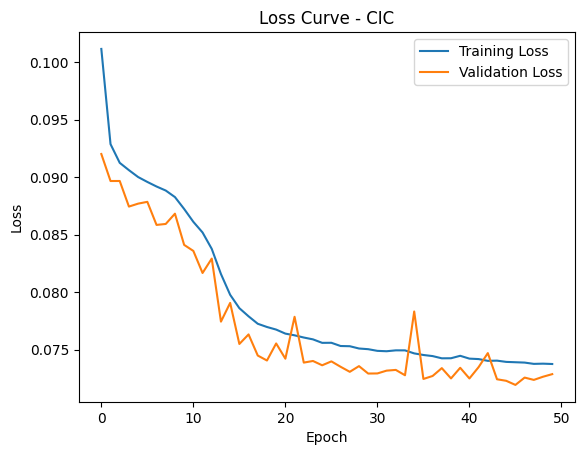

  Training Complete. Time: 3675.81s

--- Results for CIC ---
  Accuracy:  98.40%
  Precision: 98.54%
  Recall:    74.64%
  F1 Score:  84.94%
  FAR:       0.0007
  AUC:       0.9441
  Inference Time: 7.18s
------------------------------


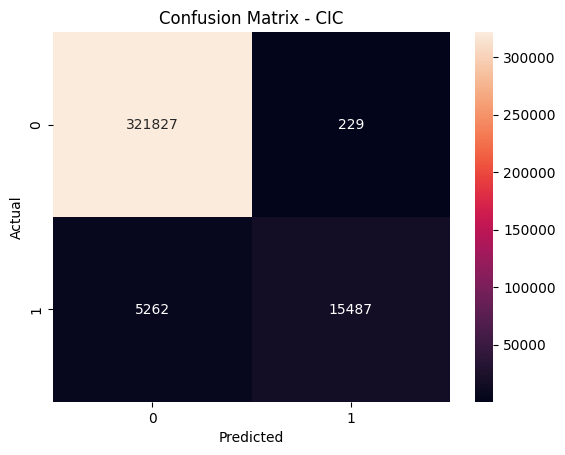

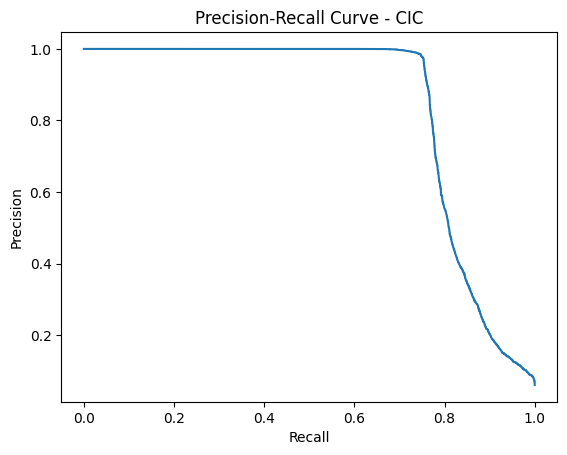

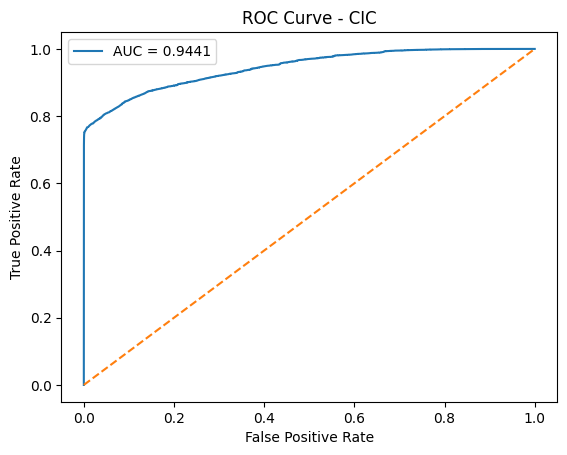


[Training] Starting training for UNSW on cuda...
  Epoch 1/50 | Train Loss: 0.3114 | Val Loss: 0.3043
  Epoch 2/50 | Train Loss: 0.2955 | Val Loss: 0.2925
  Epoch 3/50 | Train Loss: 0.2629 | Val Loss: 0.2326
  Epoch 4/50 | Train Loss: 0.2322 | Val Loss: 0.2168
  Epoch 5/50 | Train Loss: 0.2146 | Val Loss: 0.2044
  Epoch 6/50 | Train Loss: 0.2143 | Val Loss: 0.1993
  Epoch 7/50 | Train Loss: 0.2044 | Val Loss: 0.1939
  Epoch 8/50 | Train Loss: 0.1914 | Val Loss: 0.1948
  Epoch 9/50 | Train Loss: 0.1785 | Val Loss: 0.1722
  Epoch 10/50 | Train Loss: 0.1694 | Val Loss: 0.1900
  Epoch 11/50 | Train Loss: 0.1632 | Val Loss: 0.1537
  Epoch 12/50 | Train Loss: 0.1576 | Val Loss: 0.1453
  Epoch 13/50 | Train Loss: 0.1536 | Val Loss: 0.1397
  Epoch 14/50 | Train Loss: 0.1504 | Val Loss: 0.1392
  Epoch 15/50 | Train Loss: 0.1471 | Val Loss: 0.1373
  Epoch 16/50 | Train Loss: 0.1447 | Val Loss: 0.1382
  Epoch 17/50 | Train Loss: 0.1425 | Val Loss: 0.1354
  Epoch 18/50 | Train Loss: 0.1412 | Val 

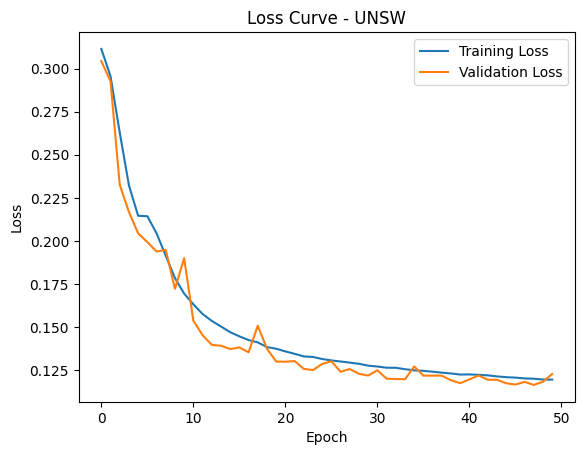

  Training Complete. Time: 684.44s

--- Results for UNSW ---
  Accuracy:  94.59%
  Precision: 80.28%
  Recall:    84.24%
  F1 Score:  82.21%
  FAR:       0.0360
  AUC:       0.9827
  Inference Time: 1.80s
------------------------------


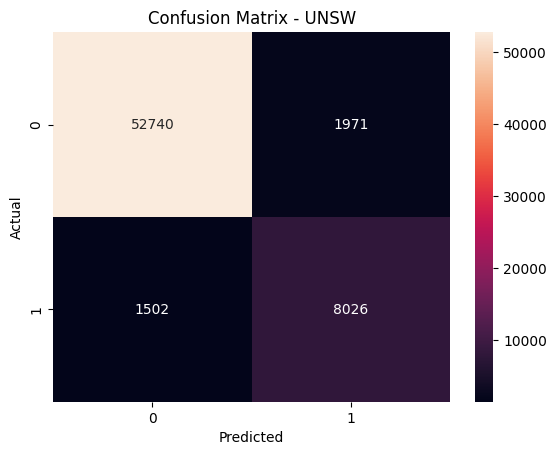

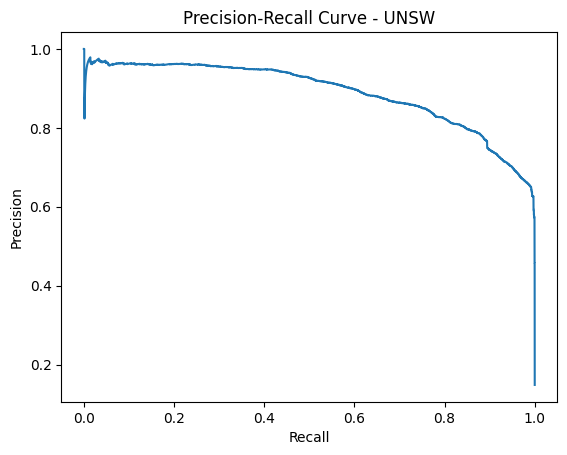

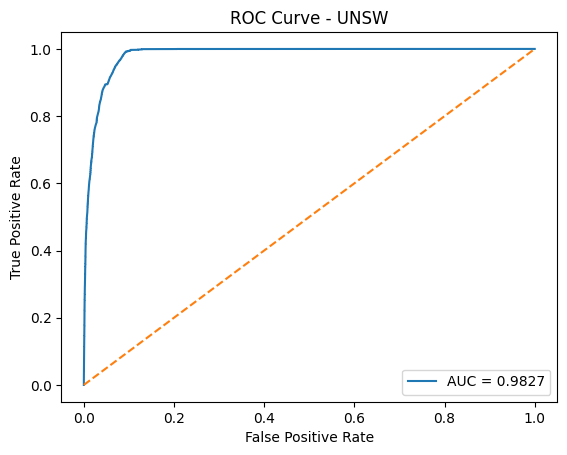

In [15]:
# Iterate through prepared datasets (UNSW first, then CIC)
if 'datasets' in globals() and datasets:
    for name, data in datasets.items():
        X_train, X_test, y_train, y_test = data

        # 1. Prepare DataLoaders
        # Batch Size 64 specified in Table 5
        train_loader, test_loader = get_dataloaders(X_train, X_test, y_train, y_test, batch_size=64)

        # 2. Instantiate Fresh Model
        model = GRU_CNN_IDS().to(device)

        # 3. Train
        model, t_time = train_model(model, train_loader, test_loader, name, device)

        # 4. Evaluate
        evaluate_model(model, test_loader, name, device)
else:
    print("No datasets found. Please run the Preprocessing step first.")